In [1]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Schrodinger1D(Problem):
    """
    Solves the 1D time-dependent Schrödinger equation for the harmonic oscillator:

         i ψ_t = -½ ψ_{xx} + ½ ω² x² ψ,

    where the complex wavefunction ψ is split into real and imaginary parts:
         ψ(x,t) = u(x,t) + i v(x,t).

    This leads to a coupled system of two real PDEs:
    
         - v_t + ½ u_{xx} - ½ ω² x² u = 0,   (Equation 1)
         u_t + ½ v_{xx} - ½ ω² x² v = 0.      (Equation 2)
    
    The initial condition is chosen to be the ground state of the harmonic oscillator:
    
         ψ(x,0) = ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2),
    
    so that u(x,0) = ψ₀(x) and v(x,0) = 0.
    
    The spatial domain is chosen as x ∈ [-L, L] (with L sufficiently large so that ψ ≈ 0 at x = ±L)
    and time t ∈ [0, T].
    """

    @staticmethod
    def init_params(omega=1.0, L=5.0, sd=0.1):
        # Define the dimensionality:
        #   ud = 2 (u, v)
        #   xd = 2 (x, t)
        static_params = {
            "dims": (2, 2),
            "omega": omega,
            "L": L,
            "sd": sd
        }
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        x_batch = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        
        # For the two equations, we need the following derivatives:
        # For Equation (1): we require u, u_{xx} and v_t.
        # For Equation (2): we require v, v_{xx} and u_t.
        required_diffs = (
            (0, ()),     # u
            (0, (0, 0)), # u_xx
            (1, (1,)),   # v_t
            (1, ()),     # v
            (1, (0, 0)), # v_xx
            (0, (1,)),   # u_t
        )
        return [[x_batch, required_diffs],]

    @staticmethod
    def constraining_fn(all_params, x_batch, net_out):
        """
        Enforces both the initial condition and the boundary conditions by reparameterizing
        the network output.
        
        Let the raw network output be:
             N(x,t) = [N_u(x,t), N_v(x,t)].
        
        We define the full solution as:
        
            u(x,t) = A(x) * t * N_u(x,t) + ψ₀(x),
            v(x,t) = A(x) * t * N_v(x,t),
        
        where:
          - A(x) = (L² - x²)/L² is a spatial multiplier that vanishes at the boundaries x = ±L,
          - ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2) is the initial wavefunction.
        
        In this way, at t = 0 the network’s contribution vanishes, ensuring that
        u(x,0) = ψ₀(x) and v(x,0) = 0, and the boundary conditions are automatically satisfied.
        """

        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        omega = all_params["static"]["problem"]["omega"]
        L = all_params["static"]["problem"]["L"]
        sd = all_params["static"]["problem"]["sd"]
        tanh = jax.nn.tanh
        
        # Constraining function
        c = tanh((L+x)/sd) * tanh((L-x)/sd)
        
        # Define the initial condition (ground state of the harmonic oscillator)
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        
        # Split the raw network output into its two components.
        u = net_out[:, 0:1]
        v = net_out[:, 1:2]
        
        # Reparameterize to enforce the conditions.
        u = c * t * u + psi0
        v = c * t * v
        # Concatenate u and v to form the full two-component output.
        return jnp.concatenate([u, v], axis=1)

    @staticmethod
    def loss_fn(all_params, constraints):
        """
        Computes the physics residual for both equations:
        
        Equation (1): -v_t + ½ u_{xx} - ½ ω² x² u = 0.
        Equation (2):  u_t + ½ v_{xx} - ½ ω² x² v = 0.
        
        The loss is defined as the sum of the mean squared errors of the residuals for
        both equations.
        """
        omega = all_params["static"]["problem"]["omega"]
        x_batch, u, uxx, vt, v, vxx, ut = constraints[0]
        
        x = x_batch[:, 0:1]
        
        res1 = -vt + 0.5 * uxx - 0.5 * omega**2 * (x**2) * u
        res2 = ut + 0.5 * vxx - 0.5 * omega**2 * (x**2) * v
        
        loss1 = jnp.mean(res1**2)
        loss2 = jnp.mean(res2**2)

        # RBA weights
        selected = all_params["trainable"]["problem"]["selected"]
        alpha = all_params["trainable"]["attention"]["alpha"][selected.astype(jnp.int32)]  # (N,1)
        # current_i = all_params["trainable"]["problem"]["current_i"][0]

        phys_residual = res1 + res2

        alpha_detached = jax.lax.stop_gradient(alpha)

        # stack residuals so we get shape (N, 2)
        residuals = jnp.stack([res1, res2], axis=1)        # (N, 2)

        # apply attention per-point (broadcast on second axis)
        loss = jnp.mean(alpha_detached[:, None] * residuals**2)
        # return loss, phys_residual

        return jnp.mean(loss1 + loss2), phys_residual

        

        # return loss1 + loss2 + attn_loss, res1 + res2
        # return loss1 + loss2, res1 + res2
        # attn_loss = jnp.mean((attention * phys_residual) ** 2)
        # m2 = jnp.mean(((jnp.exp(-current_i*0.001)+attention)*phys_residual)**2)

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        """
        Returns the exact ground-state solution for the harmonic oscillator.
        
        The analytical solution (up to a global phase) is given by:
            u(x,t) = ψ₀(x) cos(ω t/2),
            v(x,t) = -ψ₀(x) sin(ω t/2),
        where ψ₀(x) = (ω/π)^(¼) exp(-ω x²/2).
        """
        omega = all_params["static"]["problem"]["omega"]
        x = x_batch[:, 0:1]
        t = x_batch[:, 1:2]
        psi0 = (omega / jnp.pi)**0.25 * jnp.exp(-omega * x**2 / 2.0)
        u = psi0 * jnp.cos(omega * t / 2.0)
        v = -psi0 * jnp.sin(omega * t / 2.0)
        return jnp.concatenate([u, v], axis=1)


[INFO] 2025-06-06 01:43:02 - <fbpinns.constants.Constants object at 0x71758c9e64b0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-5.,  0.]), 'xmax': array([5.        , 3.14159265])}
problem: <class '__main__.Schrodinger1D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-5., -3., -1.,  1.,  3.,  5.]), array([0.        , 1.57079633, 3.14159265])], 'subdomain_ws': [array([5.8, 5.8, 5.8, 5.8, 5.8, 5.8]), array([4.55530935, 4.55530935, 4.55530935])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.StackedJacobiKAN_'>
network_init_kwargs: {'dims': [2, 4, 2], 'degrees': [4, 4]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200, 50),)
n_test: (200, 50)
sampler: grid
optimiser: <function adam at 0x71764b164f40>
optimiser_kwargs: {'learning_rate': 0.001}
seed: 0
summary_freq

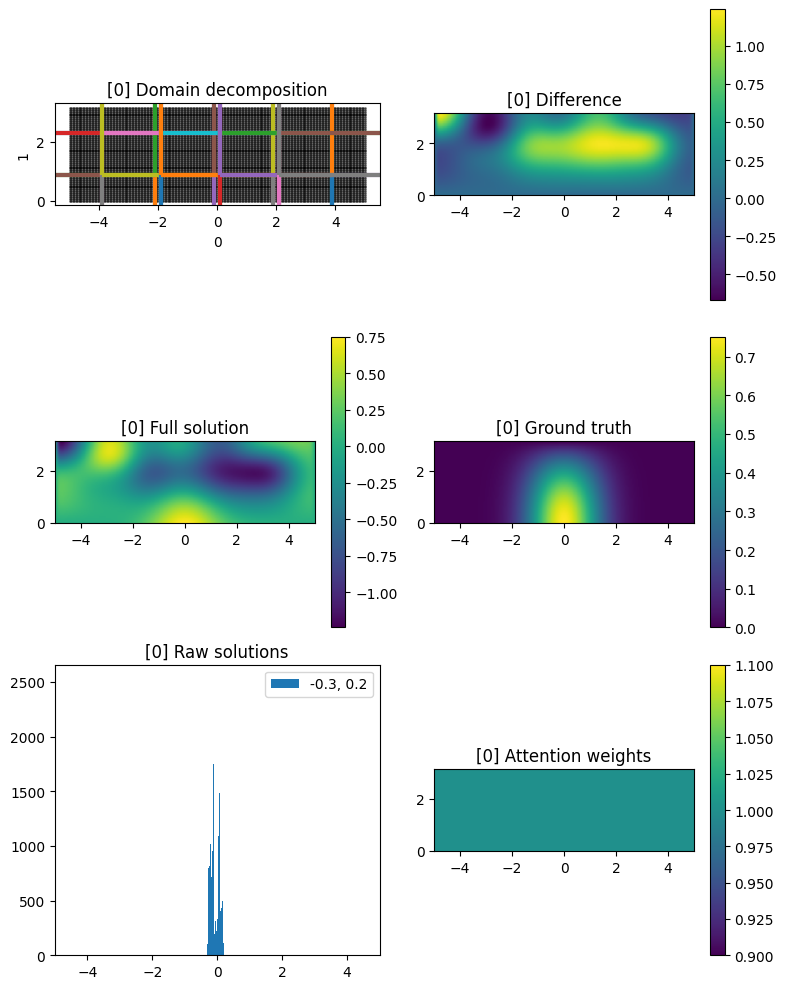

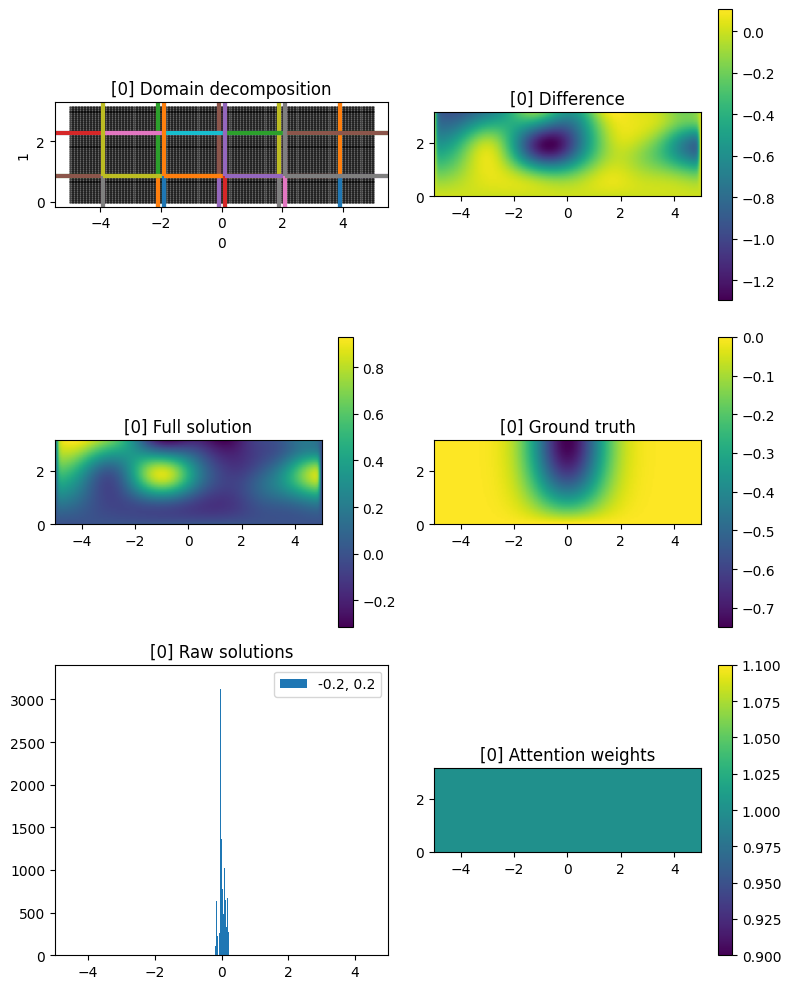

[INFO] 2025-06-06 01:43:19 - [i: 1000/20000] loss: 0.0005 rate: 125.6 elapsed: 0.00 hr test
[INFO] 2025-06-06 01:43:22 - [i: 2000/20000] loss: 0.0001 rate: 367.3 elapsed: 0.00 hr test
[INFO] 2025-06-06 01:43:25 - [i: 3000/20000] loss: 0.0001 rate: 368.1 elapsed: 0.00 hr test
[INFO] 2025-06-06 01:43:28 - [i: 4000/20000] loss: 0.0002 rate: 366.5 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:30 - [i: 5000/20000] loss: 0.0000 rate: 366.1 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:31 - saved arrays
[INFO] 2025-06-06 01:43:31 - saved arrays


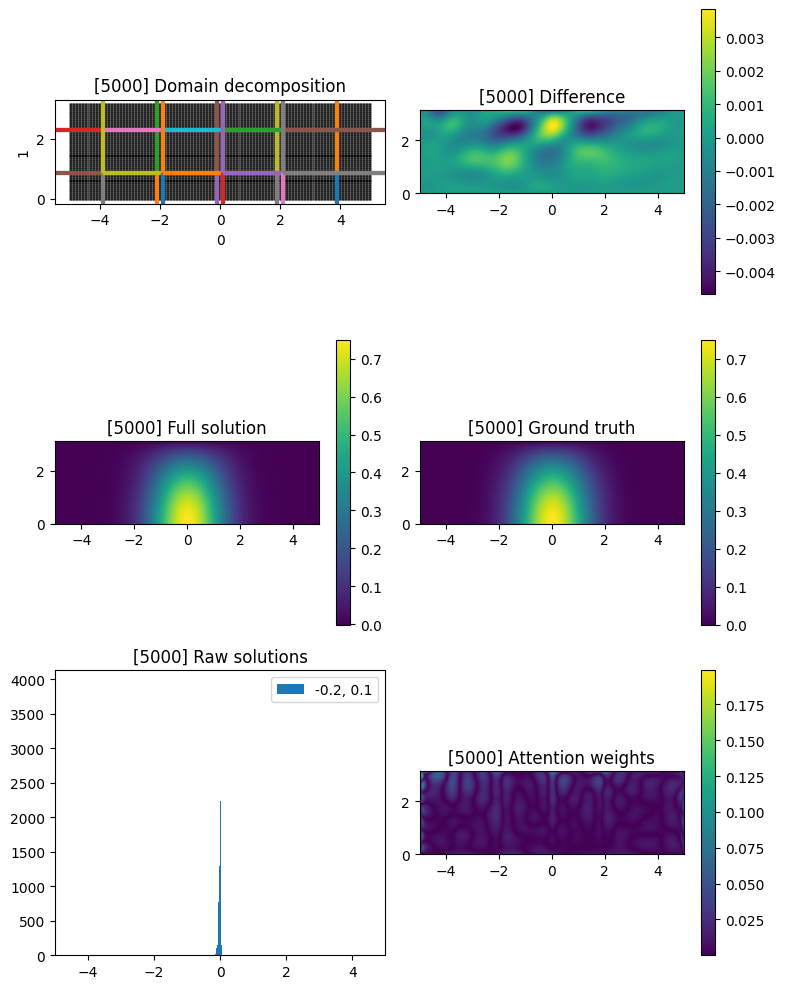

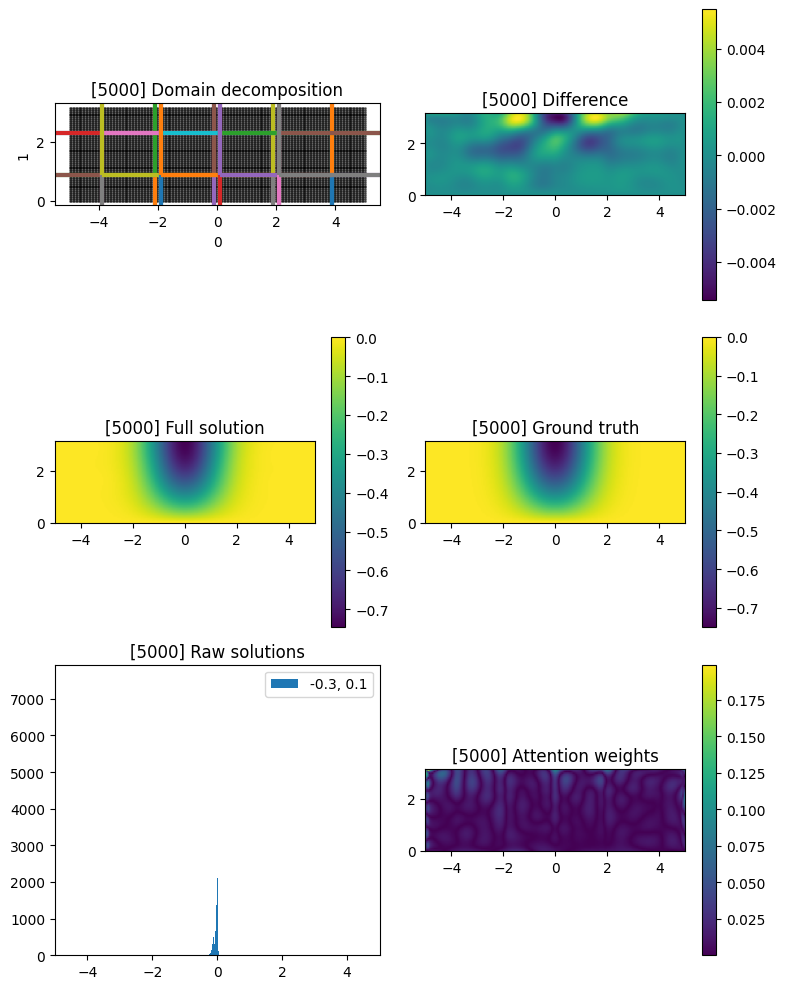

[INFO] 2025-06-06 01:43:35 - [i: 6000/20000] loss: 0.0001 rate: 361.3 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:38 - [i: 7000/20000] loss: 0.0000 rate: 365.2 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:41 - [i: 8000/20000] loss: 0.0000 rate: 363.6 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:44 - [i: 9000/20000] loss: 0.0003 rate: 362.6 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:46 - [i: 10000/20000] loss: 0.0002 rate: 365.2 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:47 - saved arrays
[INFO] 2025-06-06 01:43:47 - saved arrays


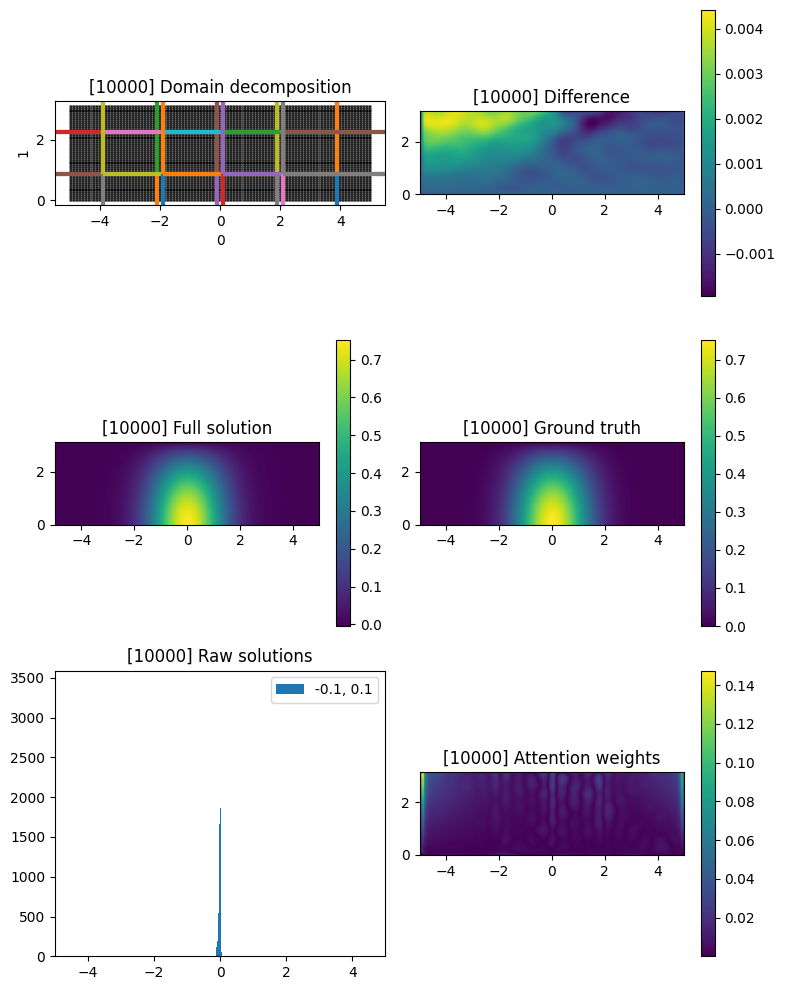

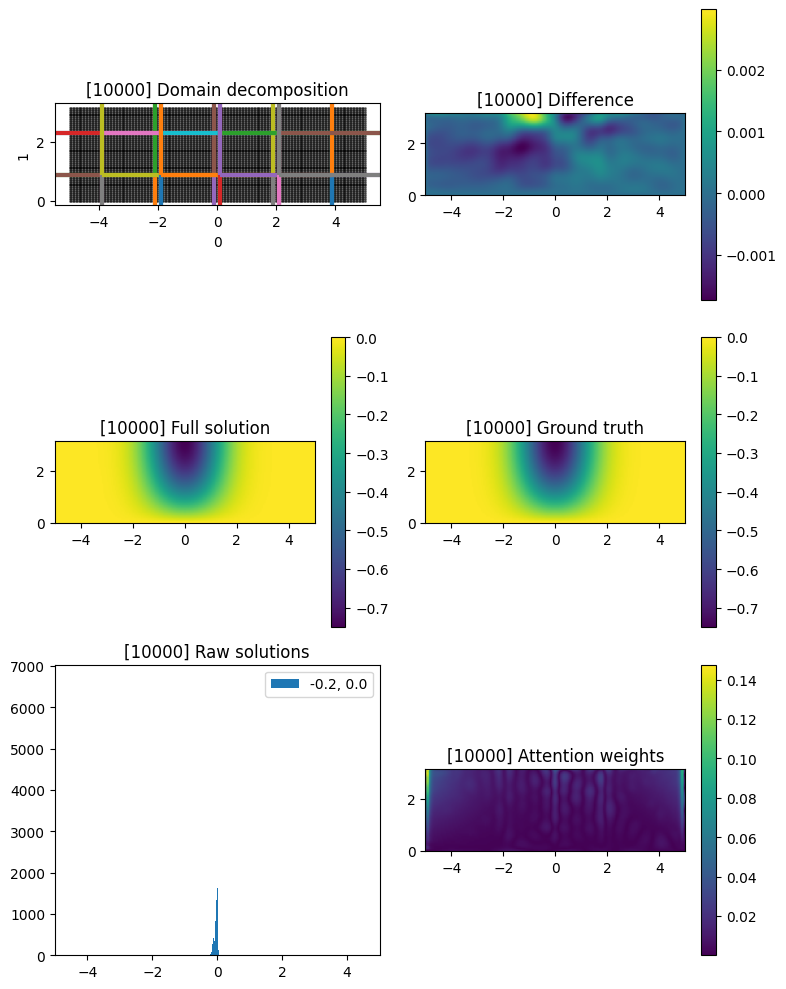

[INFO] 2025-06-06 01:43:51 - [i: 11000/20000] loss: 0.0001 rate: 359.0 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:54 - [i: 12000/20000] loss: 0.0005 rate: 370.5 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:57 - [i: 13000/20000] loss: 0.0001 rate: 362.4 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:43:59 - [i: 14000/20000] loss: 0.0000 rate: 368.1 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:44:02 - [i: 15000/20000] loss: 0.0002 rate: 361.3 elapsed: 0.01 hr test
[INFO] 2025-06-06 01:44:02 - saved arrays
[INFO] 2025-06-06 01:44:03 - saved arrays


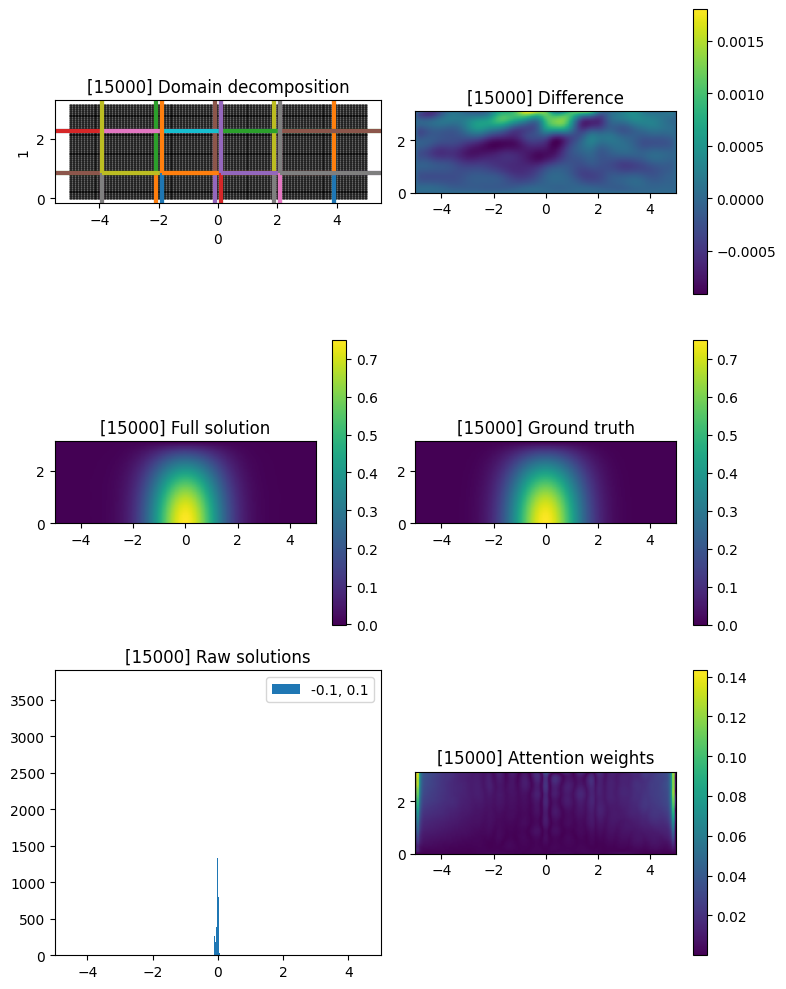

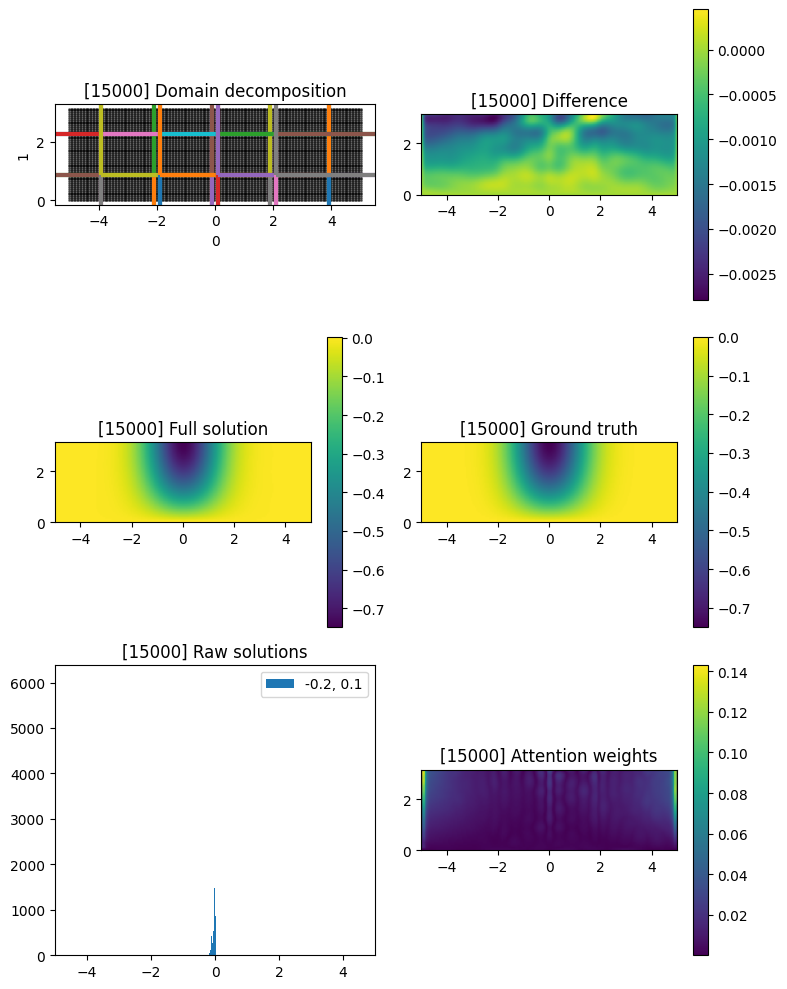

[INFO] 2025-06-06 01:44:07 - [i: 16000/20000] loss: 0.0000 rate: 361.9 elapsed: 0.02 hr test
[INFO] 2025-06-06 01:44:09 - [i: 17000/20000] loss: 0.0002 rate: 367.2 elapsed: 0.02 hr test
[INFO] 2025-06-06 01:44:12 - [i: 18000/20000] loss: 0.0007 rate: 369.5 elapsed: 0.02 hr test
[INFO] 2025-06-06 01:44:15 - [i: 19000/20000] loss: 0.0000 rate: 368.1 elapsed: 0.02 hr test
[INFO] 2025-06-06 01:44:18 - [i: 20000/20000] loss: 0.0001 rate: 361.9 elapsed: 0.02 hr test
[INFO] 2025-06-06 01:44:18 - saved arrays
[INFO] 2025-06-06 01:44:19 - saved arrays


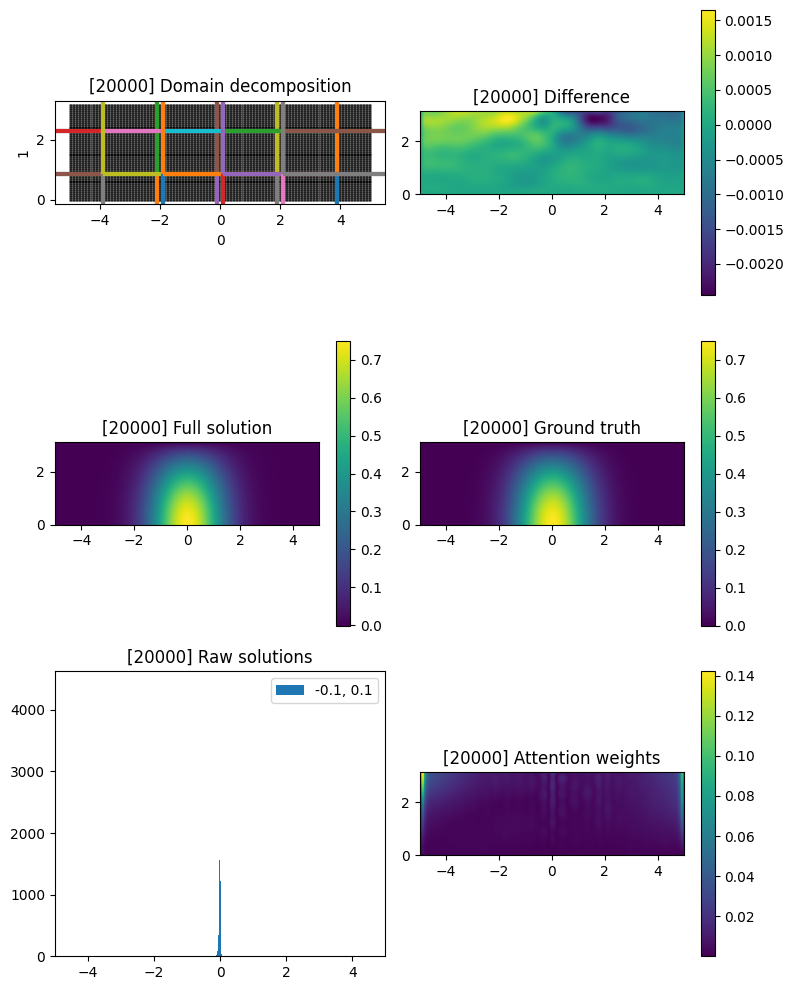

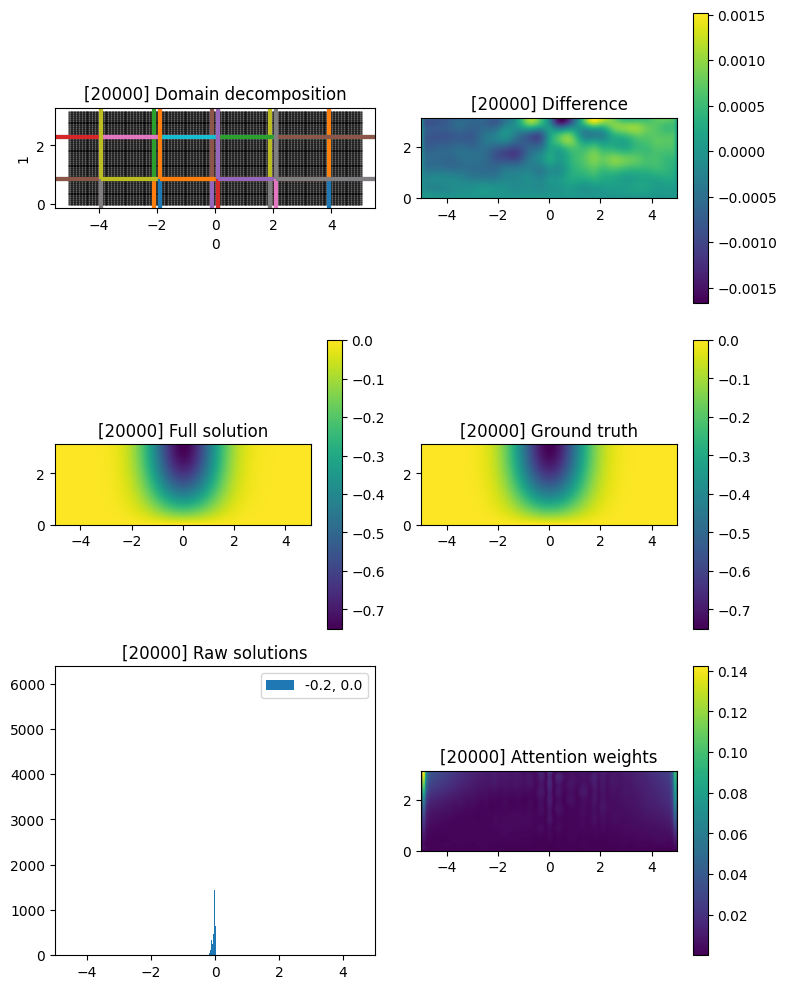

[INFO] 2025-06-06 01:44:20 - [i: 20000/20000] Training complete
[INFO] 2025-06-06 01:44:20 - [i: 20000/20000] Total training time: 71.61 s


In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import *
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

x_min, x_max = -5., 5.
t_min, t_max = 0., jnp.pi
subdomain_xs=[np.linspace(x_min, x_max, 6), np.linspace(t_min, t_max, 3)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([x_min,t_min]),
        xmax=np.array([x_max,t_max])
        ),
    problem=Schrodinger1D,
    problem_init_kwargs = dict(
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 2),
    # ),
    # network=ChebyshevKAN,
    # network_init_kwargs=dict(
    #     input_dim=2,
    #     output_dim=2,
    #     degree=10
    # ),
    network=StackedJacobiKAN_,
    network_init_kwargs=dict(
        dims=[2, 4, 2],
        degrees=[4, 4]
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,50),),
    n_test=(200,50),
    n_steps=20000,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.95,
        shape=(10000, 1)
        ),
    )


run = FBPINNTrainer(c)
all_params = run.train()